https://mlarchive.com/deep-learning/variational-autoencoders-a-vanilla-implementation/

https://towardsdatascience.com/conditional-variational-autoencoders-for-text-to-image-generation-1996da9cefcb

### Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import wandb

### Set Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


### Data Loading and Processing

In [3]:
class AFHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: path of the parent directory that contains images.
        transforms: augmentations applied to the images (can be none or more).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_mapping = {}
        
        extensions = (".jpg", ".jpeg", ".png")
        # go through all sub-directories
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            full_path = os.path.join(root_dir, category)
            if os.path.exists(full_path):
                self.class_mapping[label] = category
                for img_name in os.listdir(full_path):
                    if img_name.endswith(extensions):
                        self.image_paths.append(os.path.join(full_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
# Dataset Hyperparameters
img_size = 64
batch_size = 64

# dataset paths
train_dir = '/home/user/javeda1/stargan-v2/data/afhq/train'
val_dir = '/home/user/javeda1/stargan-v2/data/afhq/val'

### Define augmentations

In [6]:
transform = transforms.Compose([
    
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.Resize((img_size, img_size)), # image is downsampled to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [7]:
# Load the train and val dataset
train_dataset = AFHQDataset(root_dir=train_dir, transform=transform)
val_dataset = AFHQDataset(root_dir=val_dir, transform=transform)

# DataLoaders for train and val sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### Visualize Dataset

In [8]:
def visualize_dataset(dataloader, num_images=12):
    """
    Visualizes a given number of images from the given data loader.
    """
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    class_mapping = dataloader.dataset.class_mapping
    
    # creates a suitable grid
    # grid_size = int(np.ceil(np.sqrt(num_images)))
    num_rows = int(np.sqrt(num_images))
    num_cols = int(np.ceil(num_images / num_rows))
    # print(num_cols, num_rows)
    plt.figure(figsize=(6, 6))
    plt.suptitle("Sample images from AFHQ dataset")
    
    for idx in range(min(num_images, len(images))):
        plt.subplot(num_rows, num_cols, idx + 1)
        
        img = images[idx].permute(1, 2, 0).numpy()
        max_val = np.max(img)
        min_val = np.min(img)
        img = (img - min_val) / (max_val - min_val)
        
        plt.imshow(img)
        plt.title(f'Class: {class_mapping[labels[idx].item()]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

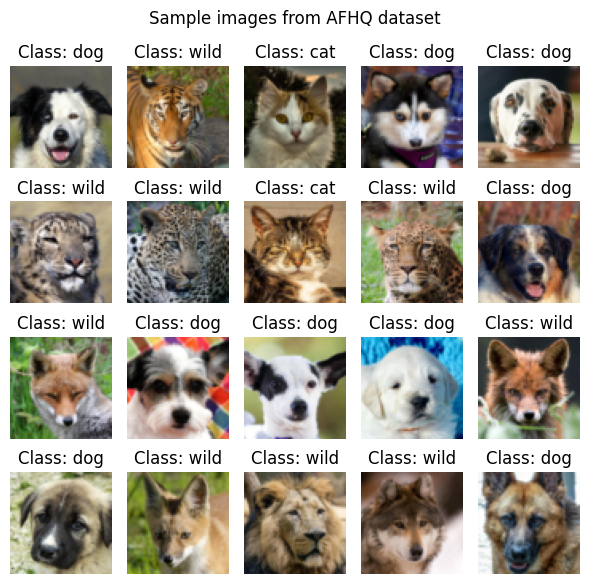

In [9]:
visualize_dataset(train_loader, num_images=20)

### Training and Validation Code

In [ ]:
def vae_loss_function(recon_x, x, mu, log_var, kl_weight=1):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_divergence * kl_weight, recon_loss, kl_divergence

def train_vae(model, train_loader, optimizer, kl_weight, device):
    model.train()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    for inputs, _ in train_loader:  #labels not used
        inputs = inputs.to(device)
        optimizer.zero_grad()
        recon_x, mu, log_var = model(inputs)
        loss, recon_loss, kl_loss = vae_loss_function(recon_x, inputs, mu, log_var, kl_weight)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
        
    dataset_size = len(train_loader.dataset)
    return {
        'total_loss': running_loss / dataset_size,
        'recon_loss': running_recon_loss / dataset_size,
        'kl_loss': running_kl_loss / dataset_size
    }

def evaluate_vae(model, val_loader, kl_weight, device):
    model.eval()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            recon_x, mu, log_var = model(inputs)
            loss, recon_loss, kl_loss = vae_loss_function(recon_x, inputs, mu, log_var, kl_weight)
            
            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()
            
    dataset_size = len(val_loader.dataset)
    return {
        'total_loss': running_loss / dataset_size,
        'recon_loss': running_recon_loss / dataset_size,
        'kl_loss': running_kl_loss / dataset_size
    }

def run_vae_training(
    model, train_loader, val_loader, device, num_epochs, learning_rate=0.001, 
    project="vae-training", name="vae_run", kl_weight=0.1, step_size=30, gamma=0.1):
    
    # Sample a small batch for visualization (adjust batch_size as needed)
    inputs, _ = next(iter(train_loader))
    inputs = inputs.to(device)
    
    # Initialize W&B logging
    wandb.init(project=project, name=name, 
               config={
                   "learning_rate": learning_rate,
                   "num_epochs": num_epochs,
                   "step_size": step_size,
                   "gamma": gamma,
                   "kl_weight": kl_weight
               })
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_metrics = train_vae(model, train_loader, optimizer, kl_weight, device)
        # Evaluate after each epoch
        val_metrics = evaluate_vae(model, val_loader, kl_weight, device)
        
        current_lr = scheduler.get_last_lr()[0]
        scheduler.step()

        # Log images to W&B
        with torch.no_grad():
            # # Sample a small batch for visualization (adjust batch_size as needed)
            # inputs, _ = next(iter(train_loader))
            # inputs = inputs[:32].to(device)
            recon_x, _, _ = model(inputs)

            # Normalize and convert to image format (assuming image data)
            recon_x = recon_x.view(-1, *inputs.shape[1:])  # Reshape to image dimensions
            recon_grid = make_grid(recon_x.cpu().detach() * 0.5 + 0.5, normalize=True, pad_value=1, padding=10)
            original_grid = make_grid(inputs.cpu().detach() * 0.5 + 0.5, normalize=True, pad_value=1, padding=10)
    
        # Log to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train/total_loss": train_metrics['total_loss'],
            "train/recon_loss": train_metrics['recon_loss'],
            "train/kl_loss": train_metrics['kl_loss'],
            "val/total_loss": val_metrics['total_loss'],
            "val/recon_loss": val_metrics['recon_loss'],
            "val/kl_loss": val_metrics['kl_loss'],
            "learning_rate": current_lr,
            "original_images": wandb.Image(original_grid),
            "reconstructed_images": wandb.Image(recon_grid),
        })
        
        # Print metrics
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Learning Rate: {current_lr:.6f}")
        print(f"Train - Total: {train_metrics['total_loss']:.4f}, "
              f"Recon: {train_metrics['recon_loss']:.4f}, "
              f"KL: {train_metrics['kl_loss']:.4f}")
        print(f"Eval  - Total: {val_metrics['total_loss']:.4f}, "
              f"Recon: {val_metrics['recon_loss']:.4f}, "
              f"KL: {val_metrics['kl_loss']:.4f}")
    
    # End W&B run
    wandb.finish()
    return model